In [1]:
!git clone https://github.com/quentgar/dip-inpainting-registration
!mv dip-inpainting-registration/* ./

Cloning into 'dip-inpainting-registration'...
remote: Enumerating objects: 1459, done.
remote: Counting objects: 100% (898/898), done.
remote: Compressing objects: 100% (601/601), done.
remote: Total 1459 (delta 438), reused 535 (delta 252), pack-reused 561
Receiving objects: 100% (1459/1459), 97.45 MiB | 31.49 MiB/s, done.
Resolving deltas: 100% (691/691), done.


# Import libs

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim
from src.utils import *
from src.hourglass_network import *
from src.Nathan import layers
from src.Nathan.hourglass_roto import *

import time
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.measure import compare_psnr

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
dim_div_by = 32

# Choose figure

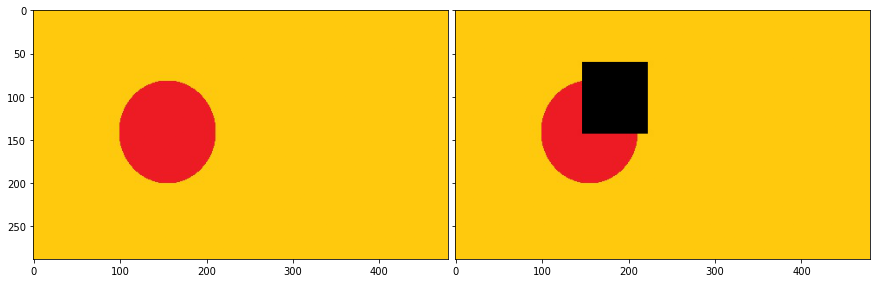

In [3]:
# img_path  = 'data/inpainting/vase.png'
# mask_path = 'data/inpainting/vase_mask.png'

#img_path  = 'data/inpainting/library.png'
#mask_path = 'data/inpainting/library_mask.png'

#img_path = 'pont.jpg'
#mask_path = 'pont_mask_6.jpg'

#img_path = 'mydata/recalage/brosse1.jpg'
#mask_path = 'mydata/recalage/brosse1_mask.jpg'

#mask_path = 'mydata/city/mask_01.jpg'
#img_path = 'mydata/city/01.jpg'

mask_path = 'mydata/recalage/image1_mask.jpg'
img_path = 'mydata/recalage/image1.jpg'

#img_path  = 'data/inpainting/kate.png'
#mask_path = 'data/inpainting/kate_mask.png'

#img_path  = 'mydata/video/car_window/07.jpg'
#mask_path = 'mydata/video/car_window/mask/mask_07.jpg'

#img_path  = 'mydata/city/18.jpg'
#mask_path = 'mydata/city/mask_phare/mask_18.jpg'

img_np = format_image(img_path, dim_div_by)
img_mask_np = format_image(mask_path, dim_div_by)
size = img_np.shape[1:]

fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [img_np, img_mask_np*img_np]):
    ax.imshow(im.transpose(1,2,0))

plt.show()

# Version Maison

In [4]:
INPUT = 'noise'
input_depth = 32
LR = 0.01 
num_iter = 1500
show_every = 100
figsize = 8
reg_noise_std = 0.03

net = build_hourglass(input_depth, img_np.shape[0],
                      num_channels_down = 128,
                      num_channels_up = 128, 
                      num_channels_skip = 0,
                      filter_size_up = 3,filter_size_down = 3,
                      num_scales = 4, 
                      up_samp_mode='nearest').type(dtype)     

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

In [5]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params: 1731971


# Main loop

Starting optimization with ADAM


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


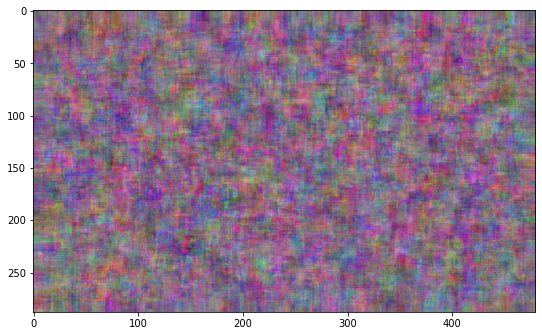

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


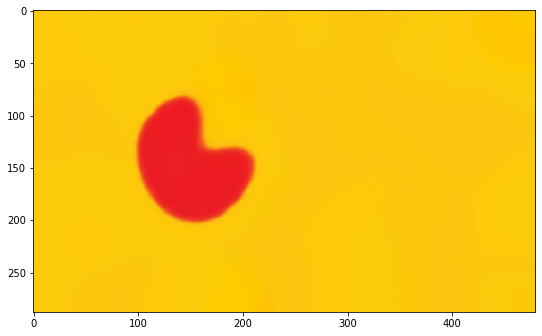

KeyboardInterrupt: ignored

In [6]:
start_time = time.time()

i = 0
list_loss = []
list_psnr = []
list_iter = []
best_psnr = 0
best_iter = 0
best_out = None
last_net = None
psnr_last = 0

def closure():
    
    global i, list_loss, list_iter, list_psnr, best_psnr, best_iter, best_out, last_net, psnr_last
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
   
    total_loss = mse(out.to('cuda:0') * mask_var.to('cuda:0'), img_var.to('cuda:0') * mask_var.to('cuda:0')).to('cuda:0')
    total_loss.backward()

    psnr_gt = compare_psnr(img_np*img_mask_np, out.detach().cpu().numpy()[0]*img_mask_np)

    if psnr_gt > best_psnr:
      best_psnr = psnr_gt
      best_iter = i
      best_out = out

        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')

        list_loss.append(total_loss.item())
        list_iter.append(i)
        psnr = compare_psnr(img_np, out_np) 
        list_psnr.append(psnr)

    """
    # Backtracking
    if i % show_every:
        if psnr_gt - psnr_last < -3: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psnr_last = psnr_gt
    """
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(net)
optimize(p, closure, LR, num_iter)

end_time = time.time()

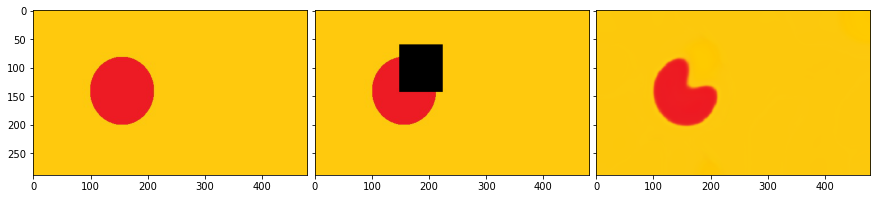

In [7]:
out = net(net_input)
out_np = torch_to_np(out)

fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [img_np, img_mask_np*img_np, out_np]):
    ax.imshow(im.transpose(1,2,0), interpolation=None)

plt.show()

In [8]:
time_ex = end_time - start_time
minutes = time_ex // 60
secondes = time_ex % 60
print( '%s minutes %s secondes' % (minutes,secondes))

NameError: ignored

134


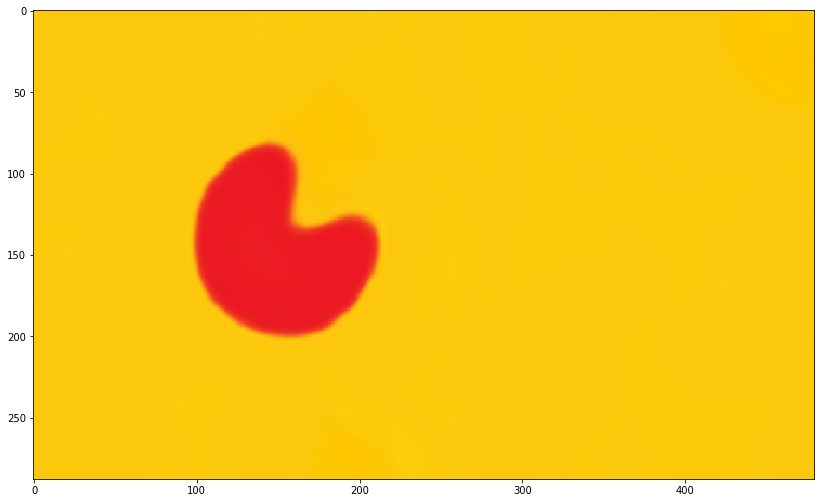

In [9]:
print(best_iter)

out_np = torch_to_np(best_out) 
plot_image_grid([out_np], factor=13);

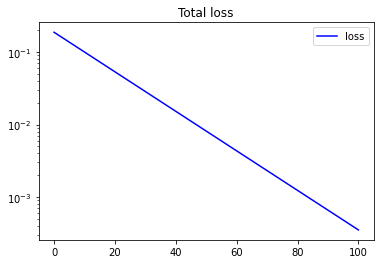

In [10]:
  plt.figure()

  plt.semilogy(list_iter, list_loss, 'b',label='loss')
  plt.title('Total loss')
  plt.legend()

  plt.show()

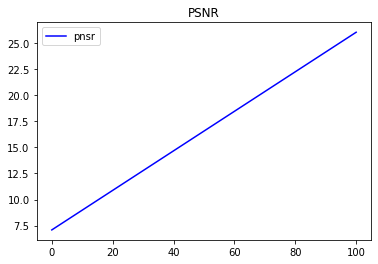

In [11]:
  plt.figure()

  plt.plot(list_iter, list_psnr, 'b',label='pnsr')
  plt.title('PSNR')
  plt.legend()

  plt.show()

In [12]:
t = out_np.transpose(1,2,0)*255
im = Image.fromarray(t.astype(np.uint8))
im.save('res.jpg')

In [13]:
t = (img_np*img_mask_np).transpose(1,2,0)*255
im = Image.fromarray(t.astype(np.uint8))
im.save('mask.jpg')